In this notebook, we analyze the learning dynamics in the nonlinear perceptron performing a classification task on well separated inputs using either SGD or RL.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from tqdm import tqdm
%matplotlib inline

In [2]:
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Root of the equation is: [1.63350617]


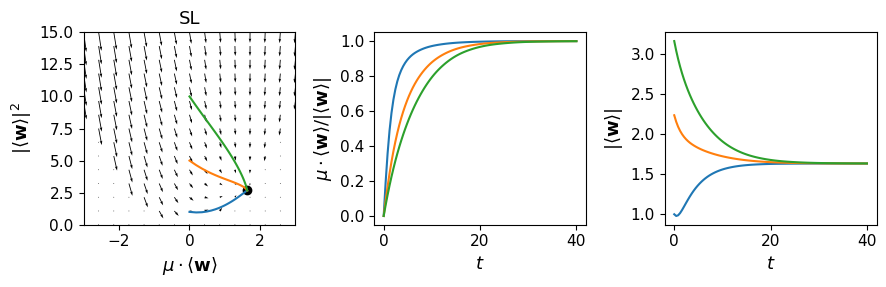

In [3]:
# Choose the learning rule:
learning = 'SGD'
# learning = 'RL'

l2_reg0 = 0.1
# l2_reg0 = 0.0

def sig(h):
    return 1 / (1 + np.exp(-h))

### FIND THE FIXED POINT ###

# To find the fixed point, define the function of which we want to find roots
def func(x, l2_reg):
    if learning == 'SGD':
        return 1 - sig(x) - l2_reg * x
    elif learning == 'RL':
        return 2 * sig(x) * sig(-x) - l2_reg * x

# Initial guess
x_initial_guess = 2.0

# Find the root of the function
x_star = fsolve(func, x_initial_guess, args=(l2_reg0,))
y_star = x_star**2
print("Root of the equation is:", x_star)

### SOLVE THE ODEs ###

# Define the system of ODEs
def system_of_odes(t, xy, l2_reg):
    if learning == 'SGD':
        dx_dt = (1 - sig(xy[0])) - l2_reg * xy[0]
        dy_dt = 2 * (1 - sig(xy[0])) * xy[0] - 2 * l2_reg * xy[1]
    elif learning == 'RL':
        dx_dt = 2 * sig(xy[0]) * sig(-xy[0]) - l2_reg * xy[0]
        dy_dt = 4 * sig(xy[0]) * sig(-xy[0]) * xy[0] - 2 * l2_reg * xy[1]
    return [dx_dt, dy_dt]

# Initial conditions
#xy0 = [[0, 1], [0, 10], [-2, 1], [-2, 10]]
xy0 = [[0, 1], [0, 5], [0, 10]]

# Time span for the solution
t_span = (0, 40)

# Time points to evaluate the solution
t_eval = np.linspace(*t_span, 100)

ode_sols = []
for i in range(len(xy0)):
    sol = solve_ivp(system_of_odes, t_span, xy0[i], args=(l2_reg0,), t_eval=t_eval)
    ode_sols.append(sol.y)

### PLOT THE FLOW FIELD AND TRAJECTORIES ###

# Create a grid of points
x = np.linspace(-3, 3, 15)
y = np.linspace(0, 15, 15)
X, Y = np.meshgrid(x, y)

# Define the vector field
if learning == 'SGD':
    Vx = ((1 - sig(X)) - l2_reg0 * X) *(X**2<Y)
    Vy = (2*(1 - sig(X)) * X - 2 * l2_reg0 * Y )* (X**2 < Y)
elif learning == 'RL':
    Vx = (2 * sig(X) * sig(-X) - l2_reg0 * X) * (X**2 < Y)
    Vy = (4 * sig(X) * sig(-X) * X - 2 * l2_reg0 * Y) * (X**2<Y)

# Normalize the vectors (this ensures they all have the same length if the exponent is 0.5)
magnitude = (Vx**2 + Vy**2)**0.25 + 1e-40
Vx_norm = Vx / magnitude
Vy_norm = Vy / magnitude

# Create the plots
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.quiver(X, Y, Vx_norm, Vy_norm, color='k')
plt.title('SL')
# Plot the fixed point
plt.plot(x_star, y_star, 'ok')

# Plot the trajectories:

# Solve the system of ODEs
for i in range(len(xy0)):
    [x_sol, y_sol] = ode_sols[i]
    plt.plot(x_sol, y_sol)

plt.xlim(-3, 3)
plt.ylim(0, 15)
plt.xlabel('$\\mu \\cdot \\langle \\mathbf{w} \\rangle$')
plt.ylabel('$| \\langle \\mathbf{w} \\rangle |^2$')

plt.subplot(132)
for i in range(len(xy0)):
    [x_sol, y_sol] = ode_sols[i]
    plt.plot(t_eval, x_sol / y_sol**0.5)
plt.xlabel('$t$')
plt.ylabel('$\\mu \\cdot \\langle \\mathbf{w} \\rangle / | \\langle \\mathbf{w} \\rangle |$')

plt.subplot(133)
for i in range(len(xy0)):
    [_, y_sol] = ode_sols[i]
    plt.plot(t_eval, y_sol**0.5)
plt.xlabel('$t$')
plt.ylabel('$|\\langle \\mathbf{w} \\rangle |$')

plt.tight_layout()
plt.savefig('figs/' + learning + '_flow1.svg')

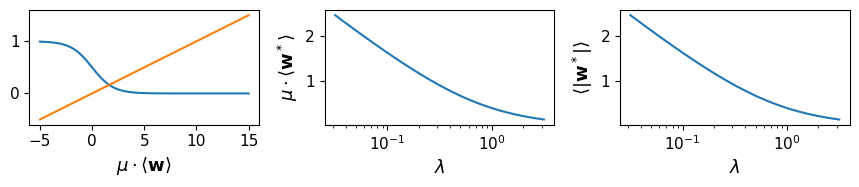

In [4]:
l2_reg_range = np.logspace(-1.5, 0.5, 21)
x_stars, y_stars = [], []
for l2_reg in l2_reg_range:
    # Find the root of the function
    sol = fsolve(func, 1.0, args=(l2_reg,))
    x_stars.append(sol)
    y_stars.append(sol)

plt.figure(figsize=(9,2))

plt.subplot(131)
xrange = np.linspace(-5, 15, 41)
if learning == 'SGD':
    # plt.plot(xrange, 1 - 0.5 * np.tanh(xrange/2))
    plt.plot(xrange, 1- sig(xrange))
elif learning == 'RL':
    plt.plot(xrange, 2 * sig(xrange) * sig(-xrange))
plt.plot(xrange, (0.1 * xrange))
plt.xlabel('$\\mu \\cdot \\langle \\mathbf{w} \\rangle$')

plt.subplot(132)
plt.semilogx(l2_reg_range, x_stars)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\mu \\cdot \\langle \\mathbf{w}^* \\rangle$')

plt.subplot(133)
plt.semilogx(l2_reg_range, y_stars)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\langle | \\mathbf{w}^* | \\rangle$')

plt.tight_layout()
plt.savefig('figs/' + learning + '_FixedPoints1.pdf')

In [5]:
import jax.numpy as jnp

In [6]:
from data_gen_x import gen_data_x
from jax.nn import sigmoid
import jax

In [7]:
def normalize(vec: jnp.array):
    return vec / jnp.sqrt(vec @ vec)

In [8]:
eta = 1e-3
l2_reg0 = 0
def sgd_iter(w: jnp.array, xy_train: jnp.array):
    x, y = xy_train[1:], xy_train[0]
    y_hat = sigmoid(w @ x)
    # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
    w +=  eta*((y-y_hat)*x - l2_reg0*w)
    norm_w = jnp.sqrt(w @ w)
    return w, jnp.array([norm_w, w@mean_1 / norm_w])

In [9]:
def get_results_sl_lownoise(seed, eta=1e-3,l2_reg0=0):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    n_x = 2
    sig_1 = (1e-1)**2*jnp.eye(n_x)
    sig_2 = (1e-1)**2*jnp.eye(n_x)
    mean_1 = normalize(jnp.array([1,1]))
    mean_2 = -mean_1
    w_orth = normalize(jnp.array([-1,1]))
    w_init = w_orth
    
    X_train_lownoise, y_train_lownoise, means = gen_data_x(key, 40000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)
    def sgd_iter(w: jnp.array, xy_train: jnp.array):
        x, y = xy_train[1:], xy_train[0]
        y_hat = sigmoid(w @ x)
        # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
        w +=  eta*((y-y_hat)*x - l2_reg0*w)
        norm_w = jnp.sqrt(w @ w)
        return w, jnp.array([norm_w, w@mean_1 / norm_w])
    train_ds_lownoise = jnp.c_[y_train_lownoise, X_train_lownoise]
    w_fin, results_sl_lownoise = jax.lax.scan(sgd_iter, w_init, train_ds_lownoise)
    return results_sl_lownoise

In [21]:
results_sl_lownoise_all=jax.vmap(lambda seed: get_results_sl_lownoise(seed))(jnp.arange(10))

In [22]:
results_sl_lownoise_mean = results_sl_lownoise_all.mean(axis=0)
results_sl_lownoise_std = results_sl_lownoise_all.std(axis=0)

In [10]:
def get_results_sl_highnoise(seed, eta=1e-3,l2_reg0=0):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    n_x = 2
    sig_1 = (1e0)**2*jnp.eye(n_x)
    sig_2 = (1e0)**2*jnp.eye(n_x)
    mean_1 = normalize(jnp.array([1,1]))
    mean_2 = -mean_1
    w_orth = normalize(jnp.array([-1,1]))
    w_init = w_orth
    
    X_train_highnoise, y_train_highnoise, means = gen_data_x(key, 40000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)
    def sgd_iter(w: jnp.array, xy_train: jnp.array):
        x, y = xy_train[1:], xy_train[0]
        y_hat = sigmoid(w @ x)
        # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
        w +=  eta*((y-y_hat)*x - l2_reg0*w)
        norm_w = jnp.sqrt(w @ w)
        return w, jnp.array([norm_w, w@mean_1 / norm_w])
    train_ds_highnoise = jnp.c_[y_train_highnoise, X_train_highnoise]
    w_fin, results_sl_highnoise = jax.lax.scan(sgd_iter, w_init, train_ds_highnoise)
    return results_sl_highnoise

In [11]:

results_sl_highnoise_all=jax.vmap(lambda seed: get_results_sl_highnoise(seed))(jnp.arange(10))

In [12]:
results_sl_highnoise_mean = results_sl_highnoise_all.mean(axis=0)
results_sl_highnoise_std = results_sl_highnoise_all.std(axis=0)

In [13]:
def get_results_rl_lownoise(seed, eta=1e-3,l2_reg0=0, alpha_r=0.9):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    n_x = 2
    sig_1 = (1e-1)**2*jnp.eye(n_x)
    sig_2 = (1e-1)**2*jnp.eye(n_x)
    mean_1 = normalize(jnp.array([1,1]))
    mean_2 = -mean_1
    w_orth = normalize(jnp.array([-1,1]))
    w_init = w_orth
    w_r_init = jnp.r_[w_init, 0, key]
    def rl_iter(w_r_key: jnp.array, xy_train: jnp.array):
        x, y = xy_train[1:], xy_train[0]
        w, r, key = w_r_key[:n_x], w_r_key[n_x], w_r_key[n_x+1:]
        key, subkey = jax.random.split(key.astype(jnp.uint32))
        y_hat = 2*jax.random.bernoulli(subkey, sigmoid(w @ x))-1
        delta = y * y_hat-r
        w += eta*(delta*y_hat*sigmoid(-y_hat*(w @ x)) * x - l2_reg0 * w)
        r = (1-alpha_r) * 1 * y_hat + alpha_r * r
        norm_w = jnp.sqrt(w @ w)
        return jnp.r_[w, r, key], jnp.array([norm_w, w@mean_1 / norm_w])
    X_train_lownoise, y_train_lownoise, means = gen_data_x(key, 40000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)
    train_ds_rl_lownoise = jnp.c_[-(-1)**y_train_lownoise, X_train_lownoise]
    w_fin, results_rl_lownoise = jax.lax.scan(rl_iter, w_r_init, train_ds_rl_lownoise)
    return results_rl_lownoise

In [14]:

results_rl_lownoise_all=jax.vmap(lambda seed: get_results_rl_lownoise(seed))(jnp.arange(10))

In [15]:
results_rl_lownoise_mean = results_rl_lownoise_all.mean(axis=0)
results_rl_lownoise_std = results_rl_lownoise_all.std(axis=0)

In [16]:
def get_results_rl_highnoise(seed, eta=1e-3,l2_reg0=0, alpha_r=0.9):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    n_x = 2
    sig_1 = (1e0)**2*jnp.eye(n_x)
    sig_2 = (1e0)**2*jnp.eye(n_x)
    mean_1 = normalize(jnp.array([1,1]))
    mean_2 = -mean_1
    w_orth = normalize(jnp.array([-1,1]))
    w_init = w_orth
    w_r_init = jnp.r_[w_init, 0, key]
    def rl_iter(w_r_key: jnp.array, xy_train: jnp.array):
        x, y = xy_train[1:], xy_train[0]
        w, r, key = w_r_key[:n_x], w_r_key[n_x], w_r_key[n_x+1:]
        key, subkey = jax.random.split(key.astype(jnp.uint32))
        y_hat = 2*jax.random.bernoulli(subkey, sigmoid(w @ x))-1
        delta = y * y_hat-r
        w += eta*(delta*y_hat*sigmoid(-y_hat*(w @ x)) * x - l2_reg0 * w)
        r = (1-alpha_r) * 1 * y_hat + alpha_r * r
        norm_w = jnp.sqrt(w @ w)
        return jnp.r_[w, r, key], jnp.array([norm_w, w@mean_1 / norm_w])
    X_train_highnoise, y_train_highnoise, means = gen_data_x(key, 40000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)
    train_ds_rl_highnoise = jnp.c_[-(-1)**y_train_highnoise, X_train_highnoise]
    w_fin, results_rl_highnoise = jax.lax.scan(rl_iter, w_r_init, train_ds_rl_highnoise)
    return results_rl_highnoise

In [17]:

results_rl_highnoise_all=jax.vmap(lambda seed: get_results_rl_highnoise(seed))(jnp.arange(10))

In [18]:
results_rl_highnoise_mean = results_rl_highnoise_all.mean(axis=0)
results_rl_highnoise_std = results_rl_highnoise_all.std(axis=0)

Load analytical results from Mathematica

In [19]:
outrlsig01 = np.loadtxt("data/outrlsig0.1.csv", delimiter=",")
outrlsig1 = np.loadtxt("data/outrlsig1.csv", delimiter=",")
outslsig01 = np.loadtxt("data/outslsig0.1.csv", delimiter=",")
outslsig1 = np.loadtxt("data/outslsig1.csv", delimiter=",")

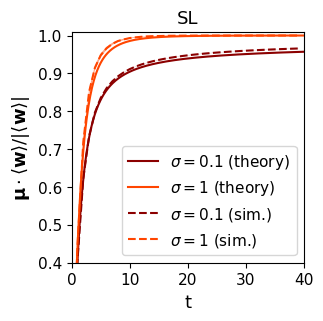

In [25]:
# plt.plot(*zip(*outrlsig01), label="RL low noise")
# plt.plot(*zip(*outrlsig1), label="RL high noise")
plt.gcf().set_size_inches(3,3)
plt.plot(*zip(*outslsig01), label="$\\sigma=0.1$ (theory)", c="darkred")
plt.plot(*zip(*outslsig1), label="$\\sigma=1$ (theory)", c="orangered")
plt.plot(results_sl_lownoise_mean[::1000,1], label="$\\sigma=0.1$ (sim.)", c="darkred", linestyle="dashed")
plt.fill_between(np.arange(40),results_sl_lownoise_mean[::1000,1]-results_sl_lownoise_std[::1000,1],
                 results_sl_lownoise_mean[::1000,1]+results_sl_lownoise_std[::1000,1],facecolor="darkred", alpha=0.5)
plt.plot(results_sl_highnoise_mean[::1000,1], label="$\\sigma=1$ (sim.)", c="orangered", linestyle="dashed")
plt.fill_between(np.arange(40),results_sl_highnoise_mean[::1000,1]-results_sl_highnoise_std[::1000,1],
                 results_sl_highnoise_mean[::1000,1]+results_sl_highnoise_std[::1000,1],facecolor="orangered", alpha=0.5)

plt.legend()
plt.ylim([0.4,1.01])
plt.xlim([0,40])
plt.xlabel("t")
plt.title("SL")
plt.ylabel("$\\mathbf{\\mu} \\cdot \\langle \\mathbf{w} \\rangle / | \\langle \\mathbf{w} \\rangle |$")
# plt.tight_layout()
plt.savefig("figs/sl_learning.svg", transparent=True, bbox_inches="tight")
plt.show()

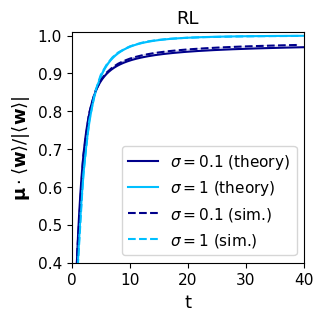

In [26]:
# plt.plot(*zip(*outrlsig01), label="RL low noise")
plt.gcf().set_size_inches(3,3)
plt.plot(*zip(*outrlsig01), label="$\\sigma=0.1$ (theory)", c="darkblue")
plt.plot(*zip(*outrlsig1), label="$\\sigma=1$ (theory)", c="deepskyblue")
plt.plot(results_rl_lownoise_mean[::1000,1], label="$\\sigma=0.1$ (sim.)", c="darkblue", linestyle="dashed")
plt.fill_between(np.arange(40),results_rl_lownoise_mean[::1000,1]-results_rl_lownoise_std[::1000,1],
                 results_rl_lownoise_mean[::1000,1]+results_rl_lownoise_std[::1000,1],facecolor="darkblue", alpha=0.5)
plt.plot(results_rl_highnoise_mean[::1000,1], label="$\\sigma=1$ (sim.)", c="deepskyblue", linestyle="dashed")
plt.fill_between(np.arange(40),results_rl_highnoise_mean[::1000,1]-results_rl_highnoise_std[::1000,1],
                 results_rl_highnoise_mean[::1000,1]+results_rl_highnoise_std[::1000,1],facecolor="deepskyblue", alpha=0.5)
plt.legend()
plt.ylim([0.4,1.01]) 
plt.xlim([0,40])
plt.xlabel("t")
plt.title("RL")
plt.ylabel("$\\mathbf{\\mu} \\cdot \\langle \\mathbf{w} \\rangle / | \\langle \\mathbf{w} \\rangle |$")
# plt.tight_layout()
plt.savefig("figs/rl_learning.svg", transparent=True, bbox_inches="tight")
plt.show()

# Forgetting

## SGD sequential learning

In [27]:
import numpy as np

In [28]:
def get_forget_curve_sgd(sig, key):
    P = 10
    n_x = 500
    forget_curve_sgd = []
    key, subkey = jax.random.split(key)
    w_notorth = jax.random.normal(subkey, shape=(n_x,))
    w_init = jnp.sqrt(1) * w_notorth
    w = w_init
    final_perf = 0.8
    key, subkey = jax.random.split(key)
    mean_1 = jax.random.normal(subkey, shape=(n_x,))
    mean_1 = mean_1 / jnp.sqrt(mean_1 @ mean_1)
    mean_init = mean_1.copy()
    mean_2 = -mean_1
    for _ in range(P):
        sig_1 = sig**2*jnp.eye(n_x)
        sig_2 = sig**2*jnp.eye(n_x)
        X_train, y_train, means = gen_data_x(key, 4000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        w = np.array(w)
        mean_init, mean_1 = np.array(mean_init), np.array(mean_1)
        eta = 1e-2
        l2_reg0 = 1e1
        train_ds = jnp.c_[y_train, X_train]
        for i in range(4000):
            x, y = X_train[i], y_train[i]
            y_hat = sigmoid(w @ x)
            # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
            w +=  eta*((y-y_hat)*x - l2_reg0*w)
            norm_w = np.sqrt(w @ w)
            if w @ mean_1 / norm_w > final_perf:
                break
        forget_curve_sgd.append(w @ mean_init / norm_w)
        key, subkey = jax.random.split(key)
        mean_1 = jax.random.normal(subkey, shape=(n_x,))
        mean_1 = mean_1 / jnp.sqrt(mean_1 @ mean_1)
        mean_2 = -mean_1
    return forget_curve_sgd

In [29]:
key = jax.random.PRNGKey(0) 

## RL sequential learning

In [30]:
def get_forget_curve_rl(sig, key):
    from scipy.special import expit
    P = 10
    n_x = 500
    forget_curve_rl = []
    key, subkey = jax.random.split(key)
    w_notorth = jax.random.normal(subkey, shape=(n_x,))
    w_init = jnp.sqrt(1) * w_notorth
    w = w_init
    final_perf = 0.8
    key, subkey = jax.random.split(key)
    mean_1 = jax.random.normal(subkey, shape=(n_x,))
    mean_1 = mean_1 / jnp.sqrt(mean_1 @ mean_1)
    mean_init = mean_1.copy()
    mean_2 = -mean_1
    for _ in range(P):
        sig_1 = sig**2*jnp.eye(n_x)
        sig_2 = sig**2*jnp.eye(n_x)
        X_train, y_train, means = gen_data_x(key, 4000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        w = np.array(w)
        mean_init, mean_1 = np.array(mean_init), np.array(mean_1)
        eta = 1e-2
        l2_reg0 = 1e1
        train_ds = jnp.c_[y_train, X_train]
        r = 0
        alpha_r = 0.9
        for i in range(4000):
            x, y = X_train[i], y_train[i]
            y_hat = 2*np.random.binomial(n=1, p=expit(w @ x))-1
            delta = y * y_hat-r
            w += eta*(delta*y_hat*expit(-y_hat*(w @ x)) * x - l2_reg0 * w)
            r = (1-alpha_r) * y * y_hat + alpha_r * r
            norm_w = np.sqrt(w @ w)
            if w @ mean_1 / norm_w > final_perf:
                break
        forget_curve_rl.append(w @ mean_init / norm_w)
        key, subkey = jax.random.split(key)
        mean_1 = jax.random.normal(subkey, shape=(n_x,))
        mean_1 = mean_1 / jnp.sqrt(mean_1 @ mean_1)
        mean_2 = -mean_1
    return forget_curve_rl

In [31]:
forget_curve_rl_lownoise = get_forget_curve_rl(0.001, key)
forget_curve_rl_highnoise = get_forget_curve_rl(0.1, key)
forget_curve_sgd_lownoise = get_forget_curve_sgd(0.001, key)
forget_curve_sgd_highnoise = get_forget_curve_sgd(0.1, key)

In [32]:
all_forget_curves_rl_lownoise, all_forget_curves_rl_highnoise, all_forget_curves_sgd_lownoise, all_forget_curves_sgd_highnoise = [], [], [], []
for i in tqdm(range(50)):
    key = jax.random.PRNGKey(i)
    np.random.seed(i)
    all_forget_curves_rl_lownoise.append(get_forget_curve_rl(0.001, key))
    all_forget_curves_rl_highnoise.append(get_forget_curve_rl(0.1, key))
    all_forget_curves_sgd_lownoise.append(get_forget_curve_sgd(0.001, key))
    all_forget_curves_sgd_highnoise.append(get_forget_curve_sgd(0.1, key))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.86s/it]


In [33]:
sgd_lownoise_mean = np.array(all_forget_curves_sgd_lownoise).mean(axis=0)
sgd_highnoise_mean = np.array(all_forget_curves_sgd_highnoise).mean(axis=0)
rl_lownoise_mean = np.array(all_forget_curves_rl_lownoise).mean(axis=0)
rl_highnoise_mean = np.array(all_forget_curves_rl_highnoise).mean(axis=0)
sgd_lownoise_std = np.array(all_forget_curves_sgd_lownoise).std(axis=0)
sgd_highnoise_std = np.array(all_forget_curves_sgd_highnoise).std(axis=0)
rl_lownoise_std = np.array(all_forget_curves_rl_lownoise).std(axis=0)
rl_highnoise_std = np.array(all_forget_curves_rl_highnoise).std(axis=0)

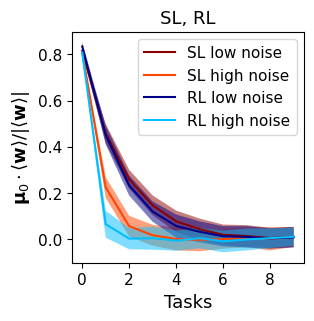

In [34]:
plt.gcf().set_size_inches(3,3)

plt.plot(sgd_lownoise_mean, label="SL low noise", c="darkred")
plt.fill_between(np.arange(10),sgd_lownoise_mean-sgd_lownoise_std, sgd_lownoise_mean+sgd_lownoise_std,facecolor="darkred", alpha=0.5)
plt.plot(sgd_highnoise_mean, label="SL high noise", c="orangered")
plt.fill_between(np.arange(10),sgd_highnoise_mean-sgd_highnoise_std, sgd_highnoise_mean+sgd_highnoise_std,facecolor="orangered", alpha=0.5)
plt.plot(rl_lownoise_mean, label="RL low noise", c="darkblue")
plt.fill_between(np.arange(10),rl_lownoise_mean-rl_lownoise_std, rl_lownoise_mean+rl_lownoise_std,facecolor="darkblue", alpha=0.5)
plt.plot(rl_highnoise_mean, label="RL high noise", c="deepskyblue")
plt.fill_between(np.arange(10),rl_highnoise_mean-rl_highnoise_std, rl_highnoise_mean+rl_highnoise_std,facecolor="deepskyblue", alpha=0.5)
plt.legend()
plt.xlabel("Tasks")
plt.ylabel("$\\mathbf{\\mu}_0 \\cdot \\langle \\mathbf{w} \\rangle / | \\langle \\mathbf{w} \\rangle |$")
plt.title("SL, RL")
plt.savefig('figs/forget_curve.svg', bbox_inches="tight")

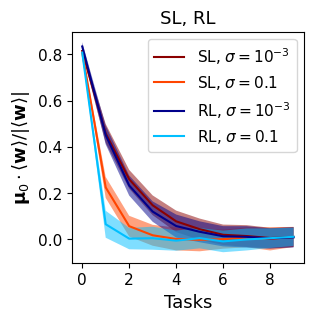

In [36]:
plt.gcf().set_size_inches(3,3)

plt.plot(sgd_lownoise_mean, label="SL, $\\sigma=10^{-3}$", c="darkred")
plt.fill_between(np.arange(10),sgd_lownoise_mean-sgd_lownoise_std, sgd_lownoise_mean+sgd_lownoise_std,facecolor="darkred", alpha=0.5)
plt.plot(sgd_highnoise_mean, label="SL, $\\sigma=0.1$", c="orangered")
plt.fill_between(np.arange(10),sgd_highnoise_mean-sgd_highnoise_std, sgd_highnoise_mean+sgd_highnoise_std,facecolor="orangered", alpha=0.5)
plt.plot(rl_lownoise_mean, label="RL, $\\sigma=10^{-3}$", c="darkblue")
plt.fill_between(np.arange(10),rl_lownoise_mean-rl_lownoise_std, rl_lownoise_mean+rl_lownoise_std,facecolor="darkblue", alpha=0.5)
plt.plot(rl_highnoise_mean, label="RL, $\\sigma=0.1$", c="deepskyblue")
plt.fill_between(np.arange(10),rl_highnoise_mean-rl_highnoise_std, rl_highnoise_mean+rl_highnoise_std,facecolor="deepskyblue", alpha=0.5)
plt.legend()
plt.xlabel("Tasks")
plt.ylabel("$\\mathbf{\\mu}_0 \\cdot \\langle \\mathbf{w} \\rangle / | \\langle \\mathbf{w} \\rangle |$")
plt.title("SL, RL")
plt.savefig('figs/forget_curve.svg', bbox_inches="tight")

In [57]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
n_x = 20
mean_1 = jnp.ones(n_x)
mean_1 = mean_1 / jnp.sqrt(mean_1 @ mean_1)
# mean_2 = jnp.arange(n_x)
mean_2 = -mean_1
sig_1 = (1e-1)**2*jnp.eye(n_x)
sig_2 = (1e-1)**2*jnp.eye(n_x)

In [58]:
w_notorth = jax.random.normal(subkey, shape=(n_x,))
w_orth = normalize(w_notorth - (w_notorth@mean_1) * mean_1)
w_init = w_orth

In [59]:

X_train, y_train, means = gen_data_x(key, 40000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2, mean_1]), vec=True)

In [60]:

train_ds = jnp.c_[y_train, X_train]

In [61]:
eta = 1e-3
l2_reg0 = 0.1
def sgd_iter_ret_w(w: jnp.array, xy_train: jnp.array):
    x, y = xy_train[1:], xy_train[0]
    y_hat = sigmoid(w @ x)
    # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
    w +=  eta*((y-y_hat)*x - l2_reg0*w)
    norm_w = jnp.sqrt(w @ w)
    return w, jnp.r_[jnp.array([norm_w, w@mean_1 / norm_w]),w]

In [62]:

w_fin, results_sl_run1 = jax.lax.scan(sgd_iter_ret_w, w_init, train_ds)

In [63]:
ws_run_1 = results_sl_run1[:,2:]

In [64]:
fin_idx_run_1 = (results_sl_run1[:,1]<0.8).sum()
init_run_2 = ws_run_1[fin_idx_run_1]

In [65]:
key, subkey = jax.random.split(key)
mean_1_run2 = normalize(jax.random.normal(subkey,shape=(n_x,)))
mean_2_run2 = -mean_1_run2
key, subkey = jax.random.split(key)
def sgd_iter_ret_w(w: jnp.array, xy_train: jnp.array):
    x, y = xy_train[1:], xy_train[0]
    y_hat = sigmoid(w @ x)
    # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
    w +=  eta*((y-y_hat)*x - l2_reg0*w)
    norm_w = jnp.sqrt(w @ w)
    return w, jnp.r_[jnp.array([norm_w, w@mean_1_run2 / norm_w]),w]
X_train, y_train, means = gen_data_x(key, 40000, n_x, 2, jnp.array([sig_1, sig_2]), jnp.array([mean_2_run2, mean_1_run2]), vec=True)
train_ds = jnp.c_[y_train, X_train]
w_fin, results_sl_run2 = jax.lax.scan(sgd_iter_ret_w, init_run_2, train_ds) 
ws_run_2 = results_sl_run2[:, 2:]
fin_idx_run_2 = (results_sl_run2[:,1]<0.8).sum()

In [66]:
ws_run_2.shape

(40000, 20)

In [67]:
fin_idx_run_2

DeviceArray(3924, dtype=int32)

In [68]:
ws_all = jnp.r_[ws_run_1[:fin_idx_run_1], ws_run_2[:fin_idx_run_2]]

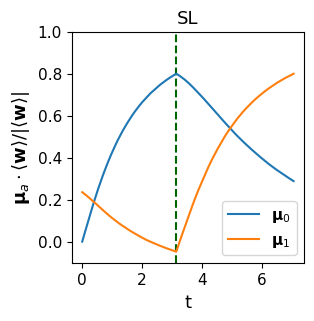

In [71]:
plt.gcf().set_size_inches(3,3)
plt.vlines(fin_idx_run_1/1000, -0.1, 1, linestyle="dashed", color="darkgreen")
plt.plot(jnp.arange(len(ws_all))/1000,mean_1 @ ws_all.T / jnp.sqrt(jnp.einsum('bi,bi->b',ws_all, ws_all)), label="$\\mathbf{\\mu}_0$")
plt.plot(jnp.arange(len(ws_all))/1000,mean_1_run2 @ ws_all.T / jnp.sqrt(jnp.einsum('bi,bi->b',ws_all, ws_all)), label="$\\mathbf{\\mu}_1$")
plt.ylabel('$\\mathbf{\\mu}_a \\cdot \\langle \\mathbf{w} \\rangle / | \\langle \\mathbf{w} \\rangle |$')
plt.xlabel('t')
plt.ylim([-0.1,1])
plt.legend(loc='lower right')
plt.title('SL')
plt.savefig('figs/forgetting_time.svg', bbox_inches="tight")

## Learn Times

Load analytical results from Mathematica

In [83]:
rllearntimes = np.loadtxt("data/outrllearntimes.csv", delimiter=",")
sllearntimes = np.loadtxt("data/outsllearntimes.csv", delimiter=",")

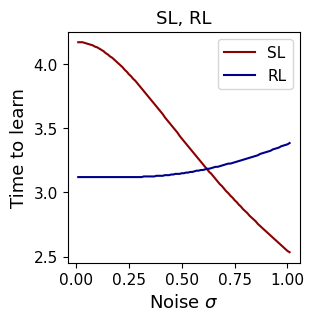

In [84]:
plt.plot(*zip(*sllearntimes), color="darkred", label="SL")
plt.plot(*zip(*rllearntimes), color="darkblue", label="RL")
plt.legend()
plt.gcf().set_size_inches(3,3)
plt.xlabel('Noise $\\sigma$')
plt.ylabel('Time to learn')
plt.title('SL, RL')
plt.savefig('figs/time_sigma.svg', bbox_inches="tight")

Load analytial results from Mathematica

In [86]:

slanlearntimes = np.loadtxt("data/outslanlearntimes.csv", delimiter=",")
rlanlearntimes = np.loadtxt("data/outrlanlearntimes.csv", delimiter=",")

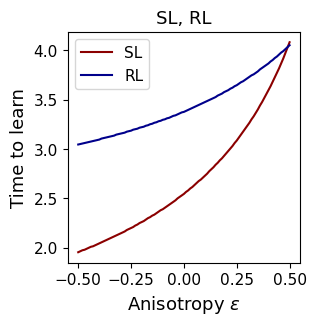

In [87]:
plt.plot(*zip(*slanlearntimes), color="darkred", label="SL")
plt.plot(*zip(*rlanlearntimes), color="darkblue", label="RL")

plt.gcf().set_size_inches(3,3)
plt.xlabel('Anisotropy $\\epsilon$')
plt.ylabel('Time to learn')
plt.title('SL, RL')
plt.legend()
plt.savefig('figs/time_sigma_an.svg', bbox_inches="tight")

## Covariance Traces

In [37]:

covtraceslsig10 = np.loadtxt("data/outcovtraceslsig10.csv", delimiter=",")
covtraceslsig05 = np.loadtxt("data/outcovtraceslsig05.csv", delimiter=",")
covtraceslsig00 = np.loadtxt("data/outcovtraceslsig00.csv", delimiter=",")
covtracerlsig10 = np.loadtxt("data/outcovtracerlsig10.csv", delimiter=",")
covtracerlsig05 = np.loadtxt("data/outcovtracerlsig05.csv", delimiter=",")
covtracerlsig00 = np.loadtxt("data/outcovtracerlsig00.csv", delimiter=",")

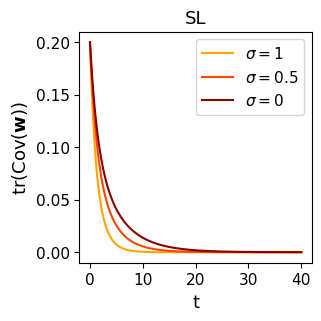

In [40]:
plt.gcf().set_size_inches(3,3)
plt.plot(*zip(*covtraceslsig10), label="$\\sigma=1$", c="orange")
plt.plot(*zip(*covtraceslsig05), label="$\\sigma=0.5$", c="orangered")
plt.plot(*zip(*covtraceslsig00), label="$\\sigma=0$", c="darkred")
plt.legend()
plt.xlabel("t")
plt.ylabel("tr(Cov($\\mathbf{w}$))")
plt.title("SL")
plt.savefig('figs/sl_trace_cov.svg', bbox_inches="tight")

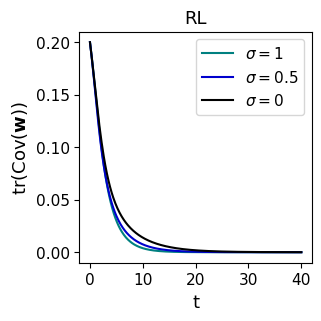

In [45]:
plt.gcf().set_size_inches(3,3)
plt.plot(*zip(*covtracerlsig10), label="$\\sigma=1$", c="teal")
plt.plot(*zip(*covtracerlsig05), label="$\\sigma=0.5$", c="mediumblue")
plt.plot(*zip(*covtracerlsig00), label="$\\sigma=0$", c="black")
plt.legend()
plt.xlabel("t")
plt.ylabel("tr(Cov($\\mathbf{w}$))")
plt.title("RL")
plt.savefig('figs/rl_trace_cov.svg', bbox_inches="tight")